In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xlrd
import seaborn as sns

In [3]:
!pip install xlrd

In [7]:
#Récupération de la base de données trouvée sur EM-DAT
data = pd.read_excel("data_catastrophes.xlsx")

# 1. Réalisons des statistiques descriptives sur la base de données

In [9]:
#Comptage du nombre de valeurs nulles pour chaque variable
data.isnull().sum()

Dis No                      0
Year                        0
Seq                         0
Disaster Group              0
Disaster Subgroup           0
Disaster Type               0
Disaster Subtype         2954
Disaster Subsubtype     14682
Event Name              11942
Entry Criteria            335
Country                     0
ISO                         0
Region                      0
Continent                   0
Location                 1788
Origin                  12107
Associated Dis          12549
Associated Dis2         15040
OFDA Response           14103
Appeal                  13142
Declaration             12502
Aid Contribution        15033
Dis Mag Value           10835
Dis Mag Scale            1167
Latitude                12996
Longitude               12993
Local Time              14624
River Basin             14462
Start Year                  0
Start Month               381
Start Day                3589
End Year                    0
End Month                 708
End Day   

On remarque que beaucoup de variables sont incomplètes: elles sont identifiables en raison de valeurs nulles ou Nan.  

Nous avons d'abord cherché à compléter la base de données mais nous nous sommes rendus compte de la difficulté de trouver des données par exemple sur le coût total des dommages pour une catastrophe donnée.

Par ailleurs, le fait que la base de données ne soit pas complète n'est pas toujours problématique, par exemple pour des variables telles que 'Disaster Subtype' ou 'Associated Dis', nous n'avons pas besoin d'avoir ces valeurs puisque un désastre n'a pas obligatoirement de sous-type ou de catastrophe associés. 

Text(0.5, 1.0, 'Nombre de catastrophe naturelles par type depuis 1900')

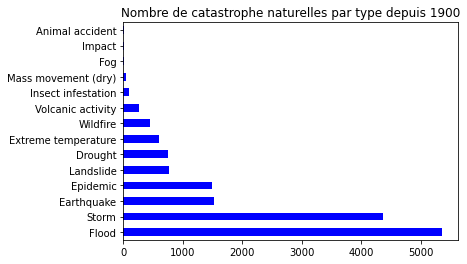

In [11]:
#Quel type de catastrophe naturelle est le plus fréquent?
dtype = data['Disaster Type'].value_counts()
dtype.plot(kind="barh", color="blue")
plt.title('Nombre de catastrophe naturelles par type depuis 1900')

Le type de catastrophes naturelles qui revient le plus dans le monde depuis 1900 sont les inondations, puisqu'elles représentent plus d'un tiers des catastrophes naturelles totales. On peut alors se dire que les zones les plus vulnérables seront celles à proximité d'océan, de mer ou de rivière.

Text(0.5, 1.0, 'Nombres de catastrophes naturelles par continent depuis 1900')

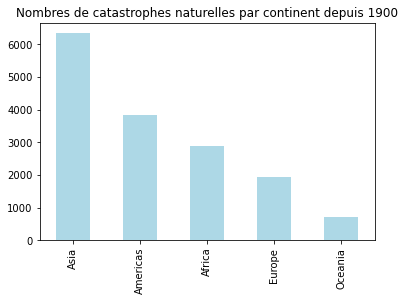

In [13]:
#Quel continent est le plus touché par les catastrophes naturelles?
dconti = data['Continent'].value_counts()
dconti.plot(kind="bar", color="lightblue")
plt.title('Nombres de catastrophes naturelles par continent depuis 1900')

Intuitivement, le continent qui pourrait être le plus touché par les catastrophes naturelles depuis 1900 est l'Asie. C'est également ce que les données démontrent. 

Le continent américain arrive en 2ème place puisqu'il a été touché par près de 3000 désastres naturelles en un peu plus d'un siècle. L'Océanie est le continent le plus épargné mais cela s'explique aisément par sa taille: il est le plus petit des 5 continents. 

Text(0.5, 1.0, 'Nombres de catastrophes naturelles dans les 10 pays les plus vulnérables')

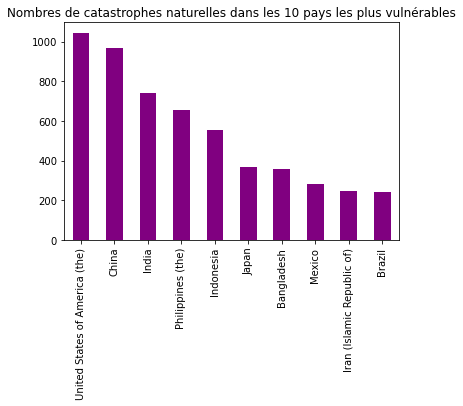

In [14]:
#Quel pays est le plus touché par les catastrophes naturelles?
dpays = data['Country'].value_counts()
dpays.head(10).plot(kind="bar", color="purple")
plt.title('Nombres de catastrophes naturelles dans les 10 pays les plus vulnérables')

Depuis 1900, les Etats-Unis et la Chine sont les 2 pays les plus touchés par les catastrophes naturelles, suivis par l'Inde, les Philippines et l'Indonésie.

On va maintenant regarder comment le coût économique des catastrophes naturelles a évolué dans le monde.

In [15]:
#Création du dataframe avec l'année et le coût total des dommages
df = pd.DataFrame(columns=['Year','Total Damages'])
for  i in range(121):
    df.loc[i, 'Year']=1900+i
    df.loc[i,'Total Damages']=data[data['Year']==(1900+i)].sum()['Total Damages']

Text(0.5, 1.0, 'Evolution du coût économique global des catastrophes naturelles depuis 1970')

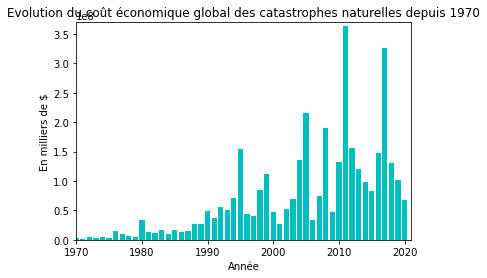

In [18]:
#Représentation graphique du coût par année
axes = plt.gca()
axes.set_xlim([1970,2021])
axes.set_ylim([0,370000000])
plt.bar(df['Year'], df['Total Damages'],width=0.8, color="c")
axes.set(xlabel = "Année", ylabel = "En milliers de $")
plt.title('Evolution du coût économique global des catastrophes naturelles depuis 1970')

La tendance est à la hausse depuis les années 1970 avec une nette augmentation des coûts économiques des catastrophes naturelles depuis les années 2000.

L'analyse descriptive nous permet de conclure que :
-les catastrophes naturelles ont plus d'intensité depuis une cinquantaine d'année
-elles touchent majoritairement l'Asie et l'Amérique
-Le coût économique des dommages causés par une catastrophe naturelles semble representer l'aspect
vulnérable ou non d'une région.

Nous allons donc nous concentrer sur le coût économique en tant que principale variable dans notre travail de modélisation.

# 2. Création d'une nouvelle variable donnant la durée de la catastrophe naturelle

Avant de faire de la modélisation, on crée une nouvelle variable contenant la durée de chaque catastrophe naturelle. La création de cette variable sera utile par la suite. 


In [19]:
#Création d'un fonction qui enlève les lignes avec un NaN ou un 0 pour une colonne donnée
def remove_nan(df,i): #i est l'indice de la colonne dans le dataframe dont on veut enlever les lignes avec NaN ou 0
    index_with_nan = df.index[df.iloc[:,i].isnull()]
    df.drop(index_with_nan,0, inplace=True)

Cette nouvelle variable 'Durée' dans le dataframe à partir de 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month' et 'End Day'. Pour cela, on supprome les catastrophes naturelles dont au moins l'une des valeurs est manquante.

In [20]:
for i in [28,29,30,31,32,33]:
    remove_nan(data,i)

In [21]:
data.describe()

,Year,Seq,Aid Contribution,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs,Insured Damages,Total Damages,CPI
count,12016.000000,12016.000000,584.000000,4.466000e+03,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,12016.000000,9049.000000,3508.00000,6.979000e+03,2.146000e+03,9.071000e+03,3.000000e+01,1.049000e+03,4.382000e+03,11717.000000
mean,1998.273053,294.735353,9680.625000,4.584041e+04,1998.281957,6.590463,15.247503,1998.296771,6.674184,15.747587,451.349873,1961.95439,6.362785e+05,7.106438e+04,5.071078e+05,2.156993e+06,7.775979e+05,7.492992e+05,66.260843
std,19.235235,310.682134,49797.639606,2.978644e+05,19.231638,3.338818,8.950169,19.239134,3.322998,8.859280,6548.004813,18702.78855,6.274358e+06,5.246601e+05,5.631714e+06,5.149240e+06,3.068046e+06,5.093811e+06,25.640175
min,1900.000000,1.000000,1.000000,-5.100000e+01,1900.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,1.000000,1.00000,1.000000e+00,6.000000e+00,1.000000e+00,8.400000e+01,3.400000e+01,2.000000e+00,3.261389
25%,1992.000000,95.000000,164.750000,7.000000e+00,1992.000000,4.000000,7.000000,1992.000000,4.000000,8.000000,5.000000,14.00000,1.200000e+03,5.400000e+02,6.000000e+02,1.100000e+04,5.000000e+04,8.000000e+03,53.271157
50%,2003.000000,256.500000,678.500000,1.530000e+02,2003.000000,7.000000,15.000000,2003.000000,7.000000,16.000000,16.000000,50.00000,9.011000e+03,3.000000e+03,5.000000e+03,1.885000e+05,1.650000e+05,6.000000e+04,70.357819
75%,2011.000000,454.250000,3389.250000,1.281825e+04,2011.000000,9.000000,23.000000,2011.000000,9.000000,24.000000,52.000000,200.00000,7.000000e+04,1.695000e+04,4.500000e+04,1.324313e+06,4.700000e+05,3.150000e+05,85.292061
max,2020.000000,9854.000000,844063.000000,1.302587e+07,2020.000000,12.000000,31.000000,2020.000000,12.000000,31.000000,300000.000000,600000.00000,2.230000e+08,1.585000e+07,2.389730e+08,2.500000e+07,6.000000e+07,2.100000e+08,100.000000


On a donc maintenant 12016 catastrophes naturelles dont on va pouvoir calculer la durée.

In [22]:
#Création da la variable contenant la durée de la catastrophe naturelle
#Utilisation du module datetime pour ce faire 

from datetime import date

data['duree']=0 #On crée la variable dans le dataframe

d0=0
d1=0

for i in range(12016) :
    d0 = date(data['Start Year'][i:i+1],data['Start Month'][i:i+1],data['Start Day'][i:i+1])
    d1 = date(data['End Year'][i:i+1],data['End Month'][i:i+1],data['End Day'][i:i+1])
    delta = d1 - d0
    data['duree'][i:i+1] = delta.days +1
  

<ipython-input-22-4be57c23170c>:12: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  d0 = date(data['Start Year'][i:i+1],data['Start Month'][i:i+1],data['Start Day'][i:i+1])
<ipython-input-22-4be57c23170c>:13: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  d1 = date(data['End Year'][i:i+1],data['End Month'][i:i+1],data['End Day'][i:i+1])
<ipython-input-22-4be57c23170c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duree'][i:i+1] = delta.days +1


In [23]:
data.duree.describe()

count    12016.000000
mean         9.459970
std         34.261889
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max        956.000000
Name: duree, dtype: float64

on remarque qu'en moyenne, la catastrophe naturelle dure une dizaine de jours.

Le maximum est 956 jours, soit environ 2 ans et demi, c'est une valeur assez extrême, qui biaise peut-être la moyenne puisque le 3ème quartile est de 5 jours.

Nous nous demandons donc s'il faut l'enlever du jeu de données.

Regardons à quelles catastrophes naturelles correspondent ces longues durées.

In [24]:
data[data['duree']>365]

,Dis No,Year,Seq,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Entry Criteria,...,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs,Insured Damages,Total Damages,CPI,duree
8808,2004-0515-CHN,2004,515,Natural,Biological,Epidemic,Viral disease,NaN,Avion Influenza H5N1,Affected,...,16.0,NaN,9.0,NaN,9.0,NaN,NaN,NaN,73.881412,885
8854,2004-0515-IDN,2004,515,Natural,Biological,Epidemic,Viral disease,NaN,Avion Influenza H5N1,Affected,...,87.0,NaN,21.0,NaN,21.0,NaN,NaN,NaN,73.881412,956
9185,2004-0515-KHM,2004,515,Natural,Biological,Epidemic,Viral disease,NaN,Avion Influenza H5N1,Affected,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.881412,784
9274,2004-0515-THA,2004,515,Natural,Biological,Epidemic,Viral disease,NaN,Avion Influenza H5N1,Affected,...,14.0,NaN,8.0,NaN,8.0,NaN,NaN,NaN,73.881412,695
10389,2008-0511-AGO,2008,511,Natural,Biological,Epidemic,Bacterial disease,NaN,Cholera,Kill,...,134.0,NaN,7495.0,NaN,7495.0,NaN,NaN,NaN,84.215229,503
11758,2010-0557-HTI,2010,557,Natural,Biological,Epidemic,Bacterial disease,NaN,Cholera,Kill,...,6908.0,277451.0,236546.0,NaN,513997.0,NaN,NaN,NaN,85.292061,420
12138,2011-0290-COD,2011,290,Natural,Biological,Epidemic,Bacterial disease,NaN,Cholera,Kill,...,603.0,NaN,22233.0,NaN,22233.0,NaN,NaN,NaN,87.984603,385
12620,2014-0090-LBR,2014,90,Natural,Biological,Epidemic,Viral disease,NaN,Ebola,Kill,...,4810.0,10682.0,NaN,NaN,10682.0,NaN,NaN,NaN,92.598981,665
12811,2012-0295-SLE,2012,295,Natural,Biological,Epidemic,Bacterial disease,NaN,Cholera,Kill,...,300.0,NaN,23009.0,NaN,23009.0,NaN,NaN,NaN,89.805293,374
13939,2015-0540-TZA,2015,540,Natural,Biological,Epidemic,Bacterial disease,NaN,Cholera,Kill,...,542.0,32879.0,NaN,NaN,32879.0,NaN,NaN,NaN,92.708822,877


Majoritairement, les catastrophes naturelles qui durent plus d'un an sont des épidémies. On choisit de garder ces valeurs car il n'y a pas qu'une seule valeur extrême isolée.

# 3. Recherche de lien entre le coût économique d'une catastrophe naturelle et d'autres variables

In [25]:
#On extraie les variables qui nous intéressent et qui nous semblent être liées à 'Total Damages'
total_damages = data['Total Damages']
duree = data.duree
total_deaths = data['Total Deaths']
total_affected = data['Total Affected']

In [26]:
#On recrée un nouveau dataframe à partir de ces variables
reg = pd.concat([total_damages,duree,total_deaths,total_affected], axis=1)
reg.isnull().sum()

Total Damages     7634
duree                0
Total Deaths      2967
Total Affected    2945
dtype: int64

On voit qu'il y a plusieurs valeurs manquantes, on enlève alors ces lignes.

In [27]:
#On enlève les lignes avec des valeurs manquantes
for i in range(4):
    remove_nan(reg,i)

On aimerait voir si on peut expliquer 'Total Damages' à partir des autres variables ou une autre de ces variables.

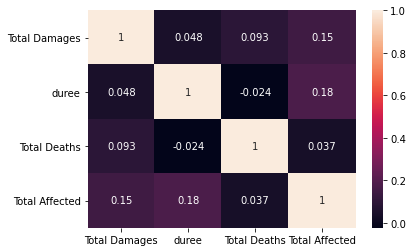

In [32]:
#Etude de la corrélation entre les variables
matrice_corr = reg.corr()
ax = sns.heatmap(matrice_corr, annot=True)
plt.show()

On voit clairement qu'il n'y a pas de réelle corrélation entre aucune de ces variables. On va représenter graphiquement les variables  avec 'Total Damages' pour essayer de comprendre leur relation.

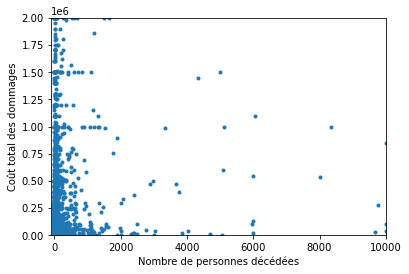

In [36]:
axes = plt.gca()
axes.set_xlim([-100,10000])
axes.set_ylim([0,2000000])
plt.plot(reg['Total Deaths'],reg['Total Damages'],'.')
axes.set(xlabel="Nombre de personnes décédées",
        ylabel = "Coût total des dommages")
plt.show()

On ne voit pas vraiment un lien entre de nombres de personnes décédées à cause d'une catastrophe naturelle et le coût total des dommages.

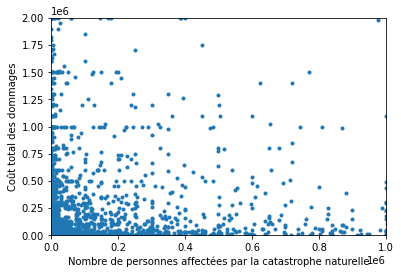

In [39]:
axes = plt.gca()
axes.set_xlim([0,1000000])
axes.set_ylim([0,2000000])
plt.plot(reg['Total Affected'],reg['Total Damages'],'.')
axes.set(xlabel="Nombre de personnes affectées par la catastrophe naturelle",
        ylabel = "Coût total des dommages")
plt.show()

On ne décèle aucune relation entre le nombre de personnes affectées par la catastrophe naturelle et son coût total.

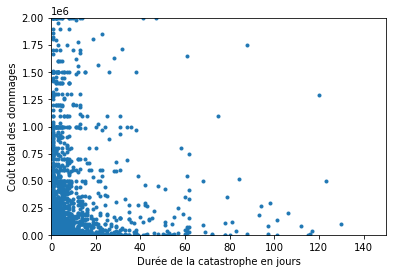

In [40]:
axes = plt.gca()
axes.set_xlim([0,150])
axes.set_ylim([0,2000000])
plt.plot(reg['duree'],reg['Total Damages'],'.')
axes.set(xlabel="Durée de la catastrophe en jours",
        ylabel = "Coût total des dommages")
plt.show()

On reconnaît un peu la fonction 1/x. On va tester un modèle log-log entre la durée de la catastrophe naturelle et le coût des dommages.

In [41]:
duree2 = np.log(reg.duree)
tot_dam = np.log(reg['Total Damages'])
reg3 = pd.concat([tot_dam, duree2], axis=1)

from sklearn.linear_model import LinearRegression

#on crée un objet reg lin
modeleReg=LinearRegression()

#on crée y et x
list_var=reg3.columns.drop('Total Damages')
y=reg3['Total Damages']
x=reg3[list_var]

modeleReg.fit(x,y)

print(modeleReg.intercept_)
print(modeleReg.coef_)

#calcul du R²

print("R² =", modeleReg.score(x,y))

10.533827356874454
[0.36198011]
R² = 0.027735709175860324


Le R² est assez faible (2,7%) donc les variations du log de la durée de la catastrophe naturelle n'expliquent pas vraiment les variations du log du coût total des dommages.

Essayons de considérer une autre variable : l'intensité de la catastrophe naturelle. On va se concentrer sur les séismes et leur magnitude car chaque type de catastrophes a sa propre unité d'intensité et ce serait donc délicat de prendre plusieurs types en même temps.

In [42]:
earthquake = data[data['Disaster Type']=="Earthquake"]
magnitude = earthquake['Dis Mag Value']
cout = earthquake['Total Damages']
reg2 = pd.concat([magnitude,cout], axis=1)
reg2.isnull().sum()

Dis Mag Value     86
Total Damages    944
dtype: int64

In [43]:
#On enlève les lignes avec des NaN
remove_nan(reg2,0);remove_nan(reg2,1)

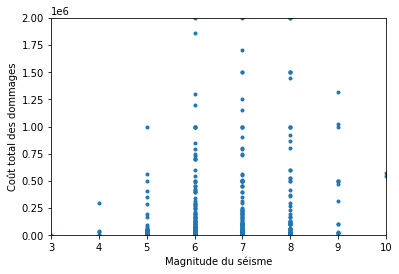

In [44]:
axes = plt.gca()
axes.set_xlim([3,10])
axes.set_ylim([0,2000000])
plt.plot(reg2['Dis Mag Value'],reg2['Total Damages'],'.')
axes.set(xlabel="Magnitude du séisme",
        ylabel = "Coût total des dommages")
plt.show()

D'après ce graphique, il semble que les 2 variables n'ait pas de relation linéaire.

In [45]:
from sklearn.linear_model import LinearRegression

#on crée un objet reg lin
modeleReg=LinearRegression()

#on crée y et x
list_var=reg2.columns.drop('Total Damages')
y=reg2['Total Damages']
x=reg2[list_var]

modeleReg.fit(x,y)

print(modeleReg.intercept_)
print(modeleReg.coef_)

#calcul du R²

print("R² =", modeleReg.score(x,y))

-7821850.957666347
[1401220.81265005]
R² = 0.018761824518818027


Le R2 reste encore faible puisqu'il vaut 1.8%, c'est-à-dire que la magnitude d'un séisme n'explique qu'environ 1,8% des variations du coût total des dommages qu'il cause. On ne va pas chercher à regresser 'Total Damages' sur la magnitude du séisme et sa durée puisqu'en général un séisme ne dure qu'une journée.



# 4. Modèle de prédiction du coût total des dommages avec Random Forest

In [56]:
#Création du dataframe contenant les features qu'on va utiliser pour le random forest

features = data.drop(['Dis No','Seq','Disaster Group','Event Name', 'ISO', 'Location', 'Origin',
                      'OFDA Response','Start Year','Start Month','Start Day', 'Country',
                      'End Year','End Month', 'End Day','CPI','Latitude','Longitude', 'Declaration', 'Appeal',
                      'River Basin','Local Time','Aid Contribution', 'Insured Damages', 'Reconstruction Costs', 
                      'Dis Mag Value','Dis Mag Scale','No Injured', 'No Homeless', 'No Affected'], axis=1)
features.columns

Index(['Year', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'Disaster Subsubtype', 'Entry Criteria', 'Region', 'Continent',
       'Associated Dis', 'Associated Dis2', 'Total Deaths', 'Total Affected',
       'Total Damages', 'duree'],
      dtype='object')

In [47]:
features.isnull().sum()

Year                       0
Disaster Subgroup          0
Disaster Type              0
Disaster Subtype        1989
Disaster Subsubtype    11074
Entry Criteria             2
Region                     0
Continent                  0
Associated Dis          9258
Associated Dis2        11408
Total Deaths            2967
Total Affected          2945
Total Damages           7634
duree                      0
dtype: int64

On doit supprimer les NaN pour le random forest quand cela représente un manque d'informations, c'est-à-dire pour 'Total Deaths', 'Total Affected' et 'Total Damages'. En effet, qu'une catatstrophe naturelle n'ait pas de catatstrophe qui en découle n'est pas un manque d'informations. De même pour les sous types.

In [48]:
nan=0
for i in [5,10,11,12]:
    remove_nan(features,i)

In [49]:
#On transforme les chaînes de caractères en variable binaires
features = pd.get_dummies(features)

In [50]:
features.describe()

,Year,Total Deaths,Total Affected,Total Damages,duree,Disaster Subgroup_Climatological,Disaster Subgroup_Geophysical,Disaster Subgroup_Hydrological,Disaster Subgroup_Meteorological,Disaster Type_Drought,...,Associated Dis2_Industrial accidents,Associated Dis2_Lightening,Associated Dis2_Liquefaction,Associated Dis2_Oil spill,Associated Dis2_Rain,"Associated Dis2_Slide (land, mud, snow, rock)",Associated Dis2_Storm,Associated Dis2_Surge,Associated Dis2_Transport accident,Associated Dis2_Tsunami/Tidal wave
count,3011.000000,3011.000000,3.011000e+03,3.011000e+03,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,...,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000,3011.000000
mean,1999.877117,872.920624,1.302950e+06,9.244193e+05,7.316174,0.020923,0.150780,0.414148,0.414148,0.000332,...,0.000332,0.002657,0.000332,0.000332,0.007971,0.048821,0.002325,0.005646,0.001661,0.002989
std,15.190644,10289.901122,9.500483e+06,6.036884e+06,15.075105,0.143151,0.357894,0.492656,0.492656,0.018224,...,0.018224,0.051485,0.018224,0.018224,0.088937,0.215529,0.048168,0.074940,0.040723,0.054599
min,1906.000000,1.000000,1.000000e+00,2.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,6.000000,3.000000e+03,1.000000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2003.000000,21.000000,2.700000e+04,6.870000e+04,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2012.000000,74.000000,2.310850e+05,3.610000e+05,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,300000.000000,2.389730e+08,2.100000e+08,336.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


On obtient alors un dataframe avec 125 colonnes au lieu de 13 à l'origine, puisque les variables qui étaient des chaînes de caractères ont été décomposées.

In [51]:
#On sépare les labels des features, les labels sont les variables qu'on veut prédire, ici on a qu'un seul label
label = np.array(features['Total Damages'])
features= features.drop('Total Damages', axis = 1)

#On garde la liste des features
feature_list = list(features.columns)

#On convertit en array
features = np.array(features)

In [52]:
#On utilise Scikit-learn pour séparer les données entre set d'entraînement et set de test
from sklearn.model_selection import train_test_split

#On sépare au hazard, en prenant 25% des données pour le set de test
train_features, test_features, train_label, test_label = train_test_split(features, label, test_size = 0.25)

In [53]:
#On vérifie que les sets d'entraînement et de test sont de la bonne dimension

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_label.shape)

Training Features Shape: (2258, 124)
Training Labels Shape: (2258,)
Testing Features Shape: (753, 124)
Testing Labels Shape: (753,)


In [54]:
#Importation du modèle qu'on va utiliser
from sklearn.ensemble import RandomForestRegressor

# On initialise le modèle avec 100 arbres de décisions
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2020)

#On entraîne le modèle sur le set d'entraînement
rf.fit(train_features, train_label);

In [55]:
# On utilise le modèle de prédiction sur le set de test
predictions = rf.predict(test_features)
# On calcule les erreurs de prédiction
erreurs = abs(predictions - test_label)
# On affiche l'erreur moyenne absolue
print('Erreur moyenne absolue:', round(np.mean(erreurs), 2), '$')

#On calcule l'erreur moyenne absolue en pourcentage
emap = 100 * (erreurs / test_label)
# Calculate and display accuracy
exactitude = 100 - np.mean(emap)
print('Exactitude du modèle:', round(exactitude, 2), '%.')

Erreur moyenne absolue: 1140940.44 $
Exactitude du modèle: -11947.8 %.


La partie prédiction du coût total des dommages avec Random Forest a constitué notre principale difficulté rencontrée

Nous avons bien :
-nettoyé le dataset en supprimant les Nan restants -utilisé scikit learn pour séparer les données entre set d'entraînement et set de test
-vérifié que les sets d'entraînement et de test sont de la bonne dimension
Pourtant, les resultats obtenus ne sont pas satisfaisants


Nous n'écartons pas la possibilité d'une erreur dans le code
mais très probablement:
- il est difficile d'expliquer le coût des dommages d'une catastrophe naturelle seulement à partir des features que nous avons dans notre base de données
-nous aurions pu prendre en compte l'intensité de la catastrophe ('Dis Mag Value') mais il y a énormément de valeurs manquantes.
-pourtant, cette base de données était l'une des plus complètes que nous sommes parvenus à trouver